[알림] '미분양수' 피처를 제거했습니다.

--- LightGBM 모델 학습 시작 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2684
[LightGBM] [Info] Number of data points in the train set: 1771, number of used features: 70
[LightGBM] [Info] Start training from score 0.818968
--- 학습 완료 ---

--- 최종 테스트 성능 (LightGBM) ---
MSE: 0.0494
MAE: 0.1462
R² Score: 0.4828

--- 피처 중요도 분석 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


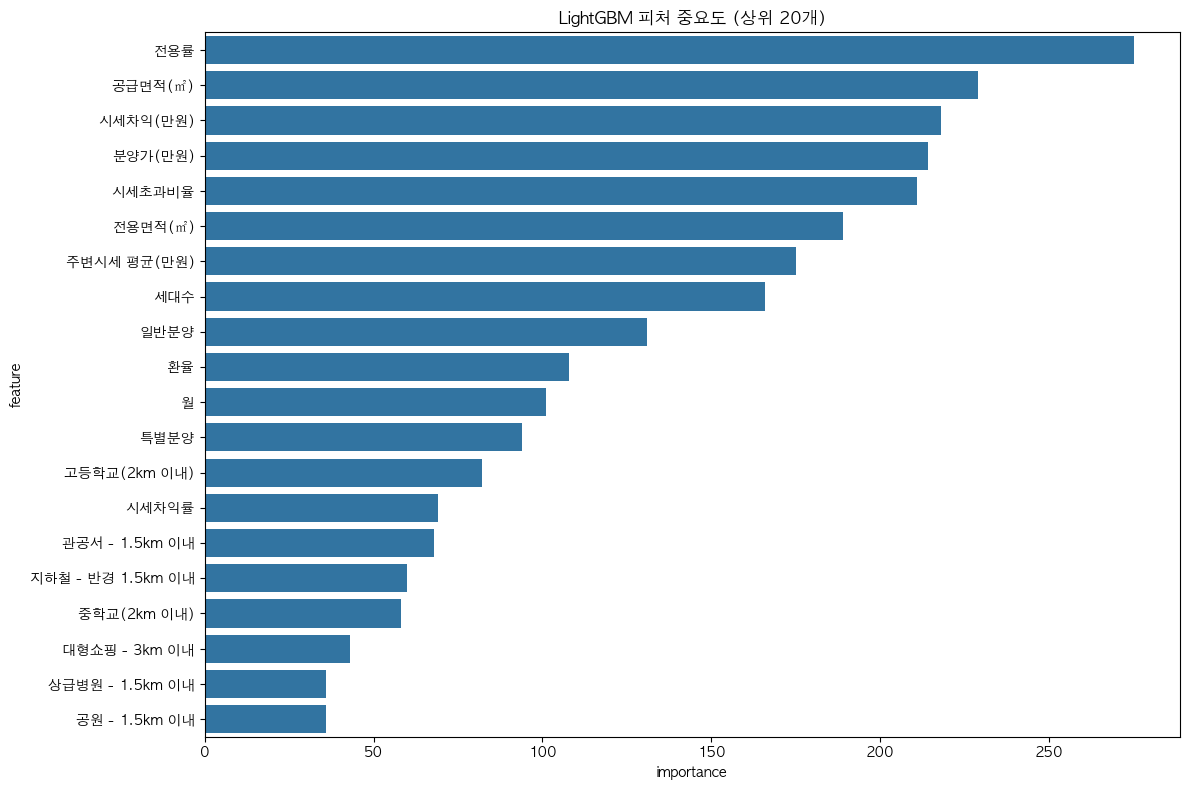


학습된 LightGBM 파이프라인이 'lgbm_model/lgbm_pipeline.joblib'에 저장되었습니다.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터셋 로드
file_name = '최종.xlsx'
try:
    df = pd.read_excel(file_name)
except FileNotFoundError:
    print(f"오류: 파일 '{file_name}'을(를) 찾을 수 없습니다.")
    exit()

# 2. 피처 전처리 및 파생 컬럼 생성 (기존과 동일)
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])
if '주변시세 평균' in df.columns: df = df.drop(columns=['주변시세 평균'])
df['분양가(만원)'] = df['분양가(만원)'].replace(0, 1)
if '주변시세 평균(만원)' in df.columns:
    df['시세초과여부'] = (df['분양가(만원)'] > df['주변시세 평균(만원)'])
    df['시세초과비율'] = ((df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']).replace([np.inf, -np.inf], np.nan).fillna(0)
else:
    df['시세초과여부'] = False
    df['시세초과비율'] = 0.0
if '시세차익(만원)' in df.columns: df['시세차익률'] = (df['시세차익(만원)'] / df['분양가(만원)']).replace([np.inf, -np.inf], np.nan).fillna(0)
if '전용면적(㎡)' in df.columns and '공급면적(㎡)' in df.columns: df['전용률'] = ((df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100).replace([np.inf, -np.inf], np.nan).fillna(0)
if '특별분양' in df.columns: df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
else: df['특별분양유무'] = 0
if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf], labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'], right=False).cat.add_categories('기타').fillna('기타')
else:
    df['금리구간'] = '기타'
    df['금리구간'] = df['금리구간'].astype('category')

# 3. 데이터 분리 및 피처 정의
target_col = '분양률'
X = df.drop(columns=[target_col])
y = df[target_col]

# (중요!) 데이터 누수 피처 제거
if '미분양수' in X.columns:
    X = X.drop(columns=['미분양수'])
    print("[알림] '미분양수' 피처를 제거했습니다.")

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 피처 그룹 정의
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
# '아파트', '지역', '건설사'는 LightGBM이 직접 처리 가능하나, 일관성을 위해 원-핫 인코딩 적용
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# 4. 전처리 파이프라인 구축
# 수치형 피처: 결측값은 중앙값으로 채우고, 스케일링 적용
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 범주형 피처: 원-핫 인코딩 적용
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 전처리기 통합
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 5. LightGBM 모델 정의 및 학습
# 전처리기와 모델을 하나의 파이프라인으로 연결
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', lgb.LGBMRegressor(random_state=42))])

print("\n--- LightGBM 모델 학습 시작 ---")
model_pipeline.fit(X_train, y_train)
print("--- 학습 완료 ---")

# 6. 예측 및 평가
y_pred = model_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- 최종 테스트 성능 (LightGBM) ---")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# 7. 피처 중요도 시각화
print("\n--- 피처 중요도 분석 ---")
# 파이프라인에서 학습된 모델과 전처리기 정보 가져오기
lgbm_model = model_pipeline.named_steps['regressor']
preprocessor_fitted = model_pipeline.named_steps['preprocessor']

# 원-핫 인코딩된 범주형 피처 이름 가져오기
ohe_feature_names = preprocessor_fitted.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
# 전체 피처 이름 순서대로 합치기
all_feature_names = numerical_features + ohe_feature_names.tolist()

# 피처 중요도 데이터프레임 생성
feature_importances = pd.DataFrame({
    'feature': all_feature_names,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

# 중요도 상위 20개만 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances.head(20))
plt.title('LightGBM 피처 중요도 (상위 20개)')
plt.tight_layout()
plt.show()

# 8. 모델 저장
model_dir = "lgbm_model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "lgbm_pipeline.joblib")
joblib.dump(model_pipeline, model_path)
print(f"\n학습된 LightGBM 파이프라인이 '{model_path}'에 저장되었습니다.")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 스태킹에 사용할 모델들
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb
import xgboost as xgb

import joblib
import os

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드 및 전처리 (이전과 동일)
file_name = '최종.xlsx'
df = pd.read_excel(file_name)
# ... (이전과 동일한 전처리 코드 생략) ...
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])
if '주변시세 평균' in df.columns: df = df.drop(columns=['주변시세 평균'])
df['분양가(만원)'] = df['분양가(만원)'].replace(0, 1)
if '주변시세 평균(만원)' in df.columns:
    df['시세초과여부'] = (df['분양가(만원)'] > df['주변시세 평균(만원)'])
    df['시세초과비율'] = ((df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']).replace([np.inf, -np.inf], np.nan).fillna(0)
else:
    df['시세초과여부'] = False
    df['시세초과비율'] = 0.0
if '시세차익(만원)' in df.columns: df['시세차익률'] = (df['시세차익(만원)'] / df['분양가(만원)']).replace([np.inf, -np.inf], np.nan).fillna(0)
if '전용면적(㎡)' in df.columns and '공급면적(㎡)' in df.columns: df['전용률'] = ((df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100).replace([np.inf, -np.inf], np.nan).fillna(0)
if '특별분양' in df.columns: df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
else: df['특별분양유무'] = 0
if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf], labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'], right=False).cat.add_categories('기타').fillna('기타')
else:
    df['금리구간'] = '기타'
    df['금리구간'] = df['금리구간'].astype('category')


# 2. 데이터 분리 및 피처 정의
target_col = '분양률'
X = df.drop(columns=[target_col])
y = df[target_col]

# 데이터 누수 피처 제거
if '미분양수' in X.columns:
    X = X.drop(columns=['미분양수'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# 3. 전처리기 정의
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 4. 스태킹 기본 모델 및 하이퍼파라미터 탐색 공간 정의 (오류 수정됨)
# =================================================================
# ## (오류 수정) 파이프라인 단계 이름('regressor')과 __ 를 추가 ##
# =================================================================
param_dist_lgbm = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7, -1],
    'regressor__num_leaves': [15, 31, 63],
}

param_dist_xgb = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.7, 0.8, 0.9],
}

param_dist_rf = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_split': [2, 5, 10],
}
# =================================================================

# 5. 랜덤 서치를 사용해 각 모델의 최적 모델 찾기
print("--- 각 모델별 최적 하이퍼파라미터 탐색 시작 ---")

pipe_lgbm = Pipeline([('preprocessor', preprocessor), 
                      ('regressor', lgb.LGBMRegressor(random_state=42, verbosity=-1))])
pipe_xgb = Pipeline([('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(random_state=42))])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])

random_search_lgbm = RandomizedSearchCV(pipe_lgbm, param_distributions=param_dist_lgbm, n_iter=20, cv=3, random_state=42, n_jobs=-1, error_score='raise')
random_search_lgbm.fit(X_train, y_train)
print(f"LGBM 최적 파라미터: {random_search_lgbm.best_params_}")

random_search_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist_xgb, n_iter=20, cv=3, random_state=42, n_jobs=-1, error_score='raise')
random_search_xgb.fit(X_train, y_train)
print(f"XGBoost 최적 파라미터: {random_search_xgb.best_params_}")

random_search_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_dist_rf, n_iter=20, cv=3, random_state=42, n_jobs=-1, error_score='raise')
random_search_rf.fit(X_train, y_train)
print(f"RandomForest 최적 파라미터: {random_search_rf.best_params_}")

best_lgbm = random_search_lgbm.best_estimator_
best_xgb = random_search_xgb.best_estimator_
best_rf = random_search_rf.best_estimator_

# 6. 스태킹 앙상블 모델 구축
print("\n--- 스태킹 모델 구축 및 학습 시작 ---")
base_estimators = [
    ('lgbm', best_lgbm),
    ('xgb', best_xgb),
    ('rf', best_rf)
]

stacking_regressor = StackingRegressor(
    estimators=base_estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5
)

# 7. 최종 스태킹 모델 학습 및 평가
stacking_regressor.fit(X_train, y_train)
print("--- 최종 모델 학습 완료 ---")

y_pred_final = stacking_regressor.predict(X_test)

mse_final = mean_squared_error(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("\n--- 최종 테스트 성능 (스태킹 + 랜덤서치) ---")
print(f"MSE: {mse_final:.4f}")
print(f"MAE: {mae_final:.4f}")
print(f"R² Score: {r2_final:.4f}")

# 8. 최종 모델 저장
model_dir = "stacking_model"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "stacking_model_final.joblib")
joblib.dump(stacking_regressor, model_path)
print(f"\n최종 스태킹 모델이 '{model_path}'에 저장되었습니다.")

--- 각 모델별 최적 하이퍼파라미터 탐색 시작 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-

LGBM 최적 파라미터: {'regressor__num_leaves': 31, 'regressor__n_estimators': 200, 'regressor__max_depth': -1, 'regressor__learning_rate': 0.05}
XGBoost 최적 파라미터: {'regressor__subsample': 0.8, 'regressor__n_estimators': 500, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1}
RandomForest 최적 파라미터: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 2, 'regressor__max_depth': None}

--- 스태킹 모델 구축 및 학습 시작 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


--- 최종 모델 학습 완료 ---

--- 최종 테스트 성능 (스태킹 + 랜덤서치) ---
MSE: 0.0395
MAE: 0.1291
R² Score: 0.5858

최종 스태킹 모델이 'stacking_model/stacking_model_final.joblib'에 저장되었습니다.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb
import xgboost as xgb
import joblib
import os

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드
file_name = '최종.xlsx'
df = pd.read_excel(file_name)

# 2. 기본 전처리 및 파생 변수 생성
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])

# 0으로 나누는 오류 방지를 위한 처리
df['분양가(만원)'] = df['분양가(만원)'].replace(0, 1)
df['공급면적(㎡)'] = df['공급면적(㎡)'].replace(0, 1)

# =================================================================
# ## (핵심) 1. 신규 파생 변수 추가 ##
# =================================================================
print("--- 신규 파생 변수 생성 ---")

# 평당 분양가 (가장 널리 쓰이는 가격 척도)
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)

# 주변 인프라 시설 개수를 합산하여 '인프라 점수' 생성
infra_cols = [
    '대형마트 - 1.5km 이내', '대형쇼핑 - 3km 이내', '편의점 - 500m 이내', '은행 - 1km 이내',
    '공원 - 1.5km 이내', '관공서 - 1.5km 이내', '상급병원 - 1.5km 이내', '상권 - 3km 이내',
    '지하철 - 반경 1.5km 이내', '버스 - 반경 500m 이내', '고속철도 - 10km 이내', '고속도로IC - 10km 이내'
]
# 데이터에 없는 인프라 컬럼은 제외하고 계산
existing_infra_cols = [col for col in infra_cols if col in df.columns]
df['인프라_점수'] = df[existing_infra_cols].sum(axis=1)
print("  - '평당분양가', '인프라_점수' 생성 완료")


# 기존 파생 변수 (NaN, inf 오류 처리 포함)
if '주변시세 평균(만원)' in df.columns:
    df['시세초과비율'] = ((df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']).replace([np.inf, -np.inf], np.nan).fillna(0)
else:
    df['시세초과여부'] = False
    df['시세초과비율'] = 0.0

if '시세차익(만원)' in df.columns:
    df['시세차익률'] = (df['시세차익(만원)'] / df['분양가(만원)']).replace([np.inf, -np.inf], np.nan).fillna(0)

df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['전용률'] = df['전용률'].replace([np.inf, -np.inf], np.nan).fillna(0)

if '특별분양' in df.columns:
    df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
else:
    df['특별분양유무'] = 0

if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf], labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'], right=False).cat.add_categories('기타').fillna('기타')
else:
    df['금리구간'] = '기타'
    df['금리구간'] = df['금리구간'].astype('category')


# =================================================================
# ## (핵심) 2. 저(低)중요도 피처 제거 ##
# =================================================================
# 이전 모델의 피처 중요도 하위권이었던 인프라 관련 개별 컬럼들을 제거
# (이미 '인프라_점수'로 종합했으므로 정보 손실 최소화)
print("\n--- 저(低)중요도 피처 제거 ---")
cols_to_drop = existing_infra_cols + ['미분양수'] # 인프라 개별 컬럼과 누수 피처
# 데이터에 존재하는 컬럼만 제거
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df_featured = df.drop(columns=existing_cols_to_drop)
print(f"  - {len(existing_cols_to_drop)}개 피처 제거 완료")


# 3. 데이터 분리 및 피처 정의
target_col = '분양률'
X = df_featured.drop(columns=[target_col])
y = df_featured[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"\n최종 학습에 사용될 수치형 피처 ({len(numerical_features)}개): {numerical_features}")
print(f"최종 학습에 사용될 범주형 피처 ({len(categorical_features)}개): {categorical_features}")

# 4. 전처리기, 모델 정의 및 하이퍼파라미터 탐색 (이전과 동일)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 파라미터 탐색 공간 (regressor__ 접두사 사용)
param_dist_lgbm = {'regressor__n_estimators': [100, 200, 500], 'regressor__learning_rate': [0.01, 0.05, 0.1], 'regressor__max_depth': [3, 5, 7, -1], 'regressor__num_leaves': [15, 31, 63]}
param_dist_xgb = {'regressor__n_estimators': [100, 200, 500], 'regressor__learning_rate': [0.01, 0.05, 0.1], 'regressor__max_depth': [3, 5, 7], 'regressor__subsample': [0.7, 0.8, 0.9]}
param_dist_rf = {'regressor__n_estimators': [100, 200, 500], 'regressor__max_depth': [5, 10, None], 'regressor__min_samples_split': [2, 5, 10]}

# 파이프라인 정의 (LGBM 경고 메시지 끄기 포함)
pipe_lgbm = Pipeline([('preprocessor', preprocessor), ('regressor', lgb.LGBMRegressor(random_state=42, verbosity=-1))])
pipe_xgb = Pipeline([('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(random_state=42))])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])

# 5. 랜덤 서치로 최적 모델 탐색
print("\n--- 각 모델별 최적 하이퍼파라미터 탐색 시작 ---")
random_search_lgbm = RandomizedSearchCV(pipe_lgbm, param_distributions=param_dist_lgbm, n_iter=20, cv=3, random_state=42, n_jobs=-1)
random_search_lgbm.fit(X_train, y_train)
print(f"LGBM 최적 파라미터: {random_search_lgbm.best_params_}")

random_search_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist_xgb, n_iter=20, cv=3, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)
print(f"XGBoost 최적 파라미터: {random_search_xgb.best_params_}")

random_search_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_dist_rf, n_iter=20, cv=3, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)
print(f"RandomForest 최적 파라미터: {random_search_rf.best_params_}")

best_lgbm = random_search_lgbm.best_estimator_
best_xgb = random_search_xgb.best_estimator_
best_rf = random_search_rf.best_estimator_

# 6. 스태킹 앙상블 모델 구축 및 학습
print("\n--- 스태킹 모델 구축 및 학습 시작 ---")
base_estimators = [('lgbm', best_lgbm), ('xgb', best_xgb), ('rf', best_rf)]
stacking_regressor = StackingRegressor(estimators=base_estimators, final_estimator=Ridge(alpha=1.0), cv=5)
stacking_regressor.fit(X_train, y_train)
print("--- 최종 모델 학습 완료 ---")

# 7. 최종 성능 평가
y_pred_final = stacking_regressor.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("\n--- 최종 테스트 성능 (피처 엔지니어링 + 스태킹 + 랜덤서치) ---")
print(f"MSE: {mse_final:.4f}")
print(f"MAE: {mae_final:.4f}")
print(f"R² Score: {r2_final:.4f}")

# 8. 최종 모델 저장
model_dir = "stacking_model_featured"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "stacking_model_featured_final.joblib")
joblib.dump(stacking_regressor, model_path)
print(f"\n피처 엔지니어링이 적용된 최종 모델이 '{model_path}'에 저장되었습니다.")

--- 신규 파생 변수 생성 ---
  - '평당분양가', '인프라_점수' 생성 완료

--- 저(低)중요도 피처 제거 ---
  - 13개 피처 제거 완료

최종 학습에 사용될 수치형 피처 (23개): ['공급면적(㎡)', '전용면적(㎡)', '일반분양', '특별분양', '세대수', '분양가(만원)', '금리', '환율', '어린이집', '유치원', '초등학교(2km 이내)', '중학교(2km 이내)', '고등학교(2km 이내)', '주변시세 평균(만원)', '시세차익(만원)', '년', '월', '평당분양가', '인프라_점수', '시세초과비율', '시세차익률', '전용률', '특별분양유무']
최종 학습에 사용될 범주형 피처 (5개): ['지역', '아파트', '준공여부', '건설사', '금리구간']

--- 각 모델별 최적 하이퍼파라미터 탐색 시작 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-

LGBM 최적 파라미터: {'regressor__num_leaves': 63, 'regressor__n_estimators': 200, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.1}
XGBoost 최적 파라미터: {'regressor__subsample': 0.8, 'regressor__n_estimators': 200, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.05}
RandomForest 최적 파라미터: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 2, 'regressor__max_depth': None}

--- 스태킹 모델 구축 및 학습 시작 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


--- 최종 모델 학습 완료 ---

--- 최종 테스트 성능 (피처 엔지니어링 + 스태킹 + 랜덤서치) ---
MSE: 0.0394
MAE: 0.1306
R² Score: 0.5878

피처 엔지니어링이 적용된 최종 모델이 'stacking_model_featured/stacking_model_featured_final.joblib'에 저장되었습니다.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
import lightgbm as lgb
import xgboost as xgb
import joblib
import os

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로드
file_name = 'final_merged_data.csv'
df = pd.read_csv(file_name)

# 2. 기본 전처리 및 파생 변수 생성
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df = df.drop(columns=['기준년월'])

if '주변시세 평균' in df.columns:
    df = df.drop(columns=['주변시세 평균'])

# 0으로 나누는 오류 방지를 위한 처리
df['분양가(만원)'] = df['분양가(만원)'].replace(0, 1)
df['공급면적(㎡)'] = df['공급면적(㎡)'].replace(0, 1)

# =================================================================
# ## (핵심) 1. 신규 파생 변수 추가 ##
# =================================================================
print("--- 신규 파생 변수 생성 ---")

# 평당 분양가 (가장 널리 쓰이는 가격 척도)
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)

# 주변 인프라 시설 개수를 합산하여 '인프라 점수' 생성
infra_cols = [
    '대형마트 - 1.5km 이내', '대형쇼핑 - 3km 이내', '편의점 - 500m 이내', '은행 - 1km 이내',
    '공원 - 1.5km 이내', '관공서 - 1.5km 이내', '상급병원 - 1.5km 이내', '상권 - 3km 이내',
    '지하철 - 반경 1.5km 이내', '버스 - 반경 500m 이내', '고속철도 - 10km 이내', '고속도로IC - 10km 이내'
]
# 데이터에 없는 인프라 컬럼은 제외하고 계산
existing_infra_cols = [col for col in infra_cols if col in df.columns]
df['인프라_점수'] = df[existing_infra_cols].sum(axis=1)
print("  - '평당분양가', '인프라_점수' 생성 완료")


# 기존 파생 변수 (NaN, inf 오류 처리 포함)
if '주변시세 평균(만원)' in df.columns:
    df['시세초과비율'] = ((df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']).replace([np.inf, -np.inf], np.nan).fillna(0)
else:
    df['시세초과여부'] = False
    df['시세초과비율'] = 0.0

if '시세차익(만원)' in df.columns:
    df['시세차익률'] = (df['시세차익(만원)'] / df['분양가(만원)']).replace([np.inf, -np.inf], np.nan).fillna(0)

df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['전용률'] = df['전용률'].replace([np.inf, -np.inf], np.nan).fillna(0)

if '특별분양' in df.columns:
    df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)
else:
    df['특별분양유무'] = 0

if '금리' in df.columns:
    df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf], labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'], right=False).cat.add_categories('기타').fillna('기타')
else:
    df['금리구간'] = '기타'
    df['금리구간'] = df['금리구간'].astype('category')


# =================================================================
# ## (핵심) 2. 저(低)중요도 피처 제거 ##
# =================================================================
# 이전 모델의 피처 중요도 하위권이었던 인프라 관련 개별 컬럼들을 제거
# (이미 '인프라_점수'로 종합했으므로 정보 손실 최소화)
print("\n--- 저(低)중요도 피처 제거 ---")
cols_to_drop = existing_infra_cols + ['미분양수'] # 인프라 개별 컬럼과 누수 피처
# 데이터에 존재하는 컬럼만 제거
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
df_featured = df.drop(columns=existing_cols_to_drop)
print(f"  - {len(existing_cols_to_drop)}개 피처 제거 완료")


# 3. 데이터 분리 및 피처 정의
target_col = '분양률'
X = df_featured.drop(columns=[target_col])
y = df_featured[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

print(f"\n최종 학습에 사용될 수치형 피처 ({len(numerical_features)}개): {numerical_features}")
print(f"최종 학습에 사용될 범주형 피처 ({len(categorical_features)}개): {categorical_features}")

# 4. 전처리기, 모델 정의 및 하이퍼파라미터 탐색 (이전과 동일)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 파라미터 탐색 공간 (regressor__ 접두사 사용)
param_dist_lgbm = {'regressor__n_estimators': [100, 200, 500], 'regressor__learning_rate': [0.01, 0.05, 0.1], 'regressor__max_depth': [3, 5, 7, -1], 'regressor__num_leaves': [15, 31, 63]}
param_dist_xgb = {'regressor__n_estimators': [100, 200, 500], 'regressor__learning_rate': [0.01, 0.05, 0.1], 'regressor__max_depth': [3, 5, 7], 'regressor__subsample': [0.7, 0.8, 0.9]}
param_dist_rf = {'regressor__n_estimators': [100, 200, 500], 'regressor__max_depth': [5, 10, None], 'regressor__min_samples_split': [2, 5, 10]}

# 파이프라인 정의 (LGBM 경고 메시지 끄기 포함)
pipe_lgbm = Pipeline([('preprocessor', preprocessor), ('regressor', lgb.LGBMRegressor(random_state=42, verbosity=-1))])
pipe_xgb = Pipeline([('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(random_state=42))])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])

# 5. 랜덤 서치로 최적 모델 탐색
print("\n--- 각 모델별 최적 하이퍼파라미터 탐색 시작 ---")
random_search_lgbm = RandomizedSearchCV(pipe_lgbm, param_distributions=param_dist_lgbm, n_iter=20, cv=3, random_state=42, n_jobs=-1)
random_search_lgbm.fit(X_train, y_train)
print(f"LGBM 최적 파라미터: {random_search_lgbm.best_params_}")

random_search_xgb = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist_xgb, n_iter=20, cv=3, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)
print(f"XGBoost 최적 파라미터: {random_search_xgb.best_params_}")

random_search_rf = RandomizedSearchCV(pipe_rf, param_distributions=param_dist_rf, n_iter=20, cv=3, random_state=42, n_jobs=-1)
random_search_rf.fit(X_train, y_train)
print(f"RandomForest 최적 파라미터: {random_search_rf.best_params_}")

best_lgbm = random_search_lgbm.best_estimator_
best_xgb = random_search_xgb.best_estimator_
best_rf = random_search_rf.best_estimator_

# 6. 스태킹 앙상블 모델 구축 및 학습
print("\n--- 스태킹 모델 구축 및 학습 시작 ---")
base_estimators = [('lgbm', best_lgbm), ('xgb', best_xgb), ('rf', best_rf)]
stacking_regressor = StackingRegressor(estimators=base_estimators, final_estimator=Ridge(alpha=1.0), cv=5)
stacking_regressor.fit(X_train, y_train)
print("--- 최종 모델 학습 완료 ---")

# 7. 최종 성능 평가
y_pred_final = stacking_regressor.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("\n--- 최종 테스트 성능 (피처 엔지니어링 + 스태킹 + 랜덤서치) ---")
print(f"MSE: {mse_final:.4f}")
print(f"MAE: {mae_final:.4f}")
print(f"R² Score: {r2_final:.4f}")

# 8. 최종 모델 저장
model_dir = "stacking_model_featured"
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "stacking_model_featured_final.joblib")
joblib.dump(stacking_regressor, model_path)
print(f"\n피처 엔지니어링이 적용된 최종 모델이 '{model_path}'에 저장되었습니다.")

--- 신규 파생 변수 생성 ---
  - '평당분양가', '인프라_점수' 생성 완료

--- 저(低)중요도 피처 제거 ---
  - 13개 피처 제거 완료

최종 학습에 사용될 수치형 피처 (25개): ['공급면적(㎡)', '전용면적(㎡)', '일반분양', '특별분양', '세대수', '분양가(만원)', '금리', '환율', '어린이집', '유치원', '초등학교(2km 이내)', '중학교(2km 이내)', '고등학교(2km 이내)', '주변시세 평균(만원)', '시세차익(만원)', 'KB매매가격지수', 'Close', '년', '월', '평당분양가', '인프라_점수', '시세초과비율', '시세차익률', '전용률', '특별분양유무']
최종 학습에 사용될 범주형 피처 (5개): ['지역', '아파트', '준공여부', '건설사', '금리구간']

--- 각 모델별 최적 하이퍼파라미터 탐색 시작 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-

LGBM 최적 파라미터: {'regressor__num_leaves': 63, 'regressor__n_estimators': 200, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.1}
XGBoost 최적 파라미터: {'regressor__subsample': 0.8, 'regressor__n_estimators': 500, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1}
RandomForest 최적 파라미터: {'regressor__n_estimators': 100, 'regressor__min_samples_split': 2, 'regressor__max_depth': None}

--- 스태킹 모델 구축 및 학습 시작 ---


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


--- 최종 모델 학습 완료 ---

--- 최종 테스트 성능 (피처 엔지니어링 + 스태킹 + 랜덤서치) ---
MSE: 0.0398
MAE: 0.1304
R² Score: 0.5832

피처 엔지니어링이 적용된 최종 모델이 'stacking_model_featured/stacking_model_featured_final.joblib'에 저장되었습니다.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import xgboost as xgb

# 데이터 로드
df = pd.read_csv("final_merged_data.csv")
df['기준년월'] = pd.to_datetime(df['기준년월'])
df['년'] = df['기준년월'].dt.year
df['월'] = df['기준년월'].dt.month
df.drop(columns=['기준년월', '미분양수', '주변시세 평균'], inplace=True)

# 안전한 나눗셈 처리
df['분양가(만원)'].replace(0, 1, inplace=True)
df['공급면적(㎡)'].replace(0, 1, inplace=True)

# 파생 변수 생성
infra_cols = [col for col in df.columns if 'km' in col or '500m' in col]
df['평당분양가'] = df['분양가(만원)'] / (df['공급면적(㎡)'] / 3.3)
df['인프라_점수'] = df[infra_cols].sum(axis=1)

df['시세초과비율'] = ((df['분양가(만원)'] - df['주변시세 평균(만원)']) / df['주변시세 평균(만원)']).replace([np.inf, -np.inf], np.nan).fillna(0)
df['시세차익률'] = (df['시세차익(만원)'] / df['분양가(만원)']).replace([np.inf, -np.inf], np.nan).fillna(0)
df['전용률'] = (df['전용면적(㎡)'] / df['공급면적(㎡)']) * 100
df['세대당면적'] = df['공급면적(㎡)'] / df['세대수']
df['특별분양유무'] = df['특별분양'].apply(lambda x: 1 if x > 0 else 0)

df['금리구간'] = pd.cut(df['금리'], bins=[1, 2.5, 3.0, 3.5, np.inf],
                        labels=['1~2.5%', '2.5~3.0%', '3.0~3.5%', '3.5%~'], right=False).astype('category')

# 학습용 데이터 구성
target = '분양률'
drop_cols = infra_cols + ['주변시세 평균(만원)', '시세차익(만원)', '분양률']
X = df.drop(columns=drop_cols)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 전처리
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

# 모델 정의
pipe_lgbm = Pipeline([('preprocessor', preprocessor), ('regressor', lgb.LGBMRegressor(random_state=42))])
pipe_xgb = Pipeline([('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(random_state=42))])
pipe_rf = Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])

# 하이퍼파라미터 탐색 공간
param_dist_lgbm = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7, -1],
    'regressor__num_leaves': [15, 31, 63]
}
param_dist_xgb = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 5, 7],
    'regressor__subsample': [0.7, 0.8, 0.9]
}
param_dist_rf = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__max_depth': [5, 10, None],
    'regressor__min_samples_split': [2, 5, 10]
}

# RandomizedSearchCV
search_lgbm = RandomizedSearchCV(pipe_lgbm, param_dist_lgbm, n_iter=30, cv=5, n_jobs=-1, random_state=42)
search_xgb = RandomizedSearchCV(pipe_xgb, param_dist_xgb, n_iter=30, cv=5, n_jobs=-1, random_state=42)
search_rf = RandomizedSearchCV(pipe_rf, param_dist_rf, n_iter=30, cv=5, n_jobs=-1, random_state=42)

search_lgbm.fit(X_train, y_train)
search_xgb.fit(X_train, y_train)
search_rf.fit(X_train, y_train)

# 최적 모델 추출
best_lgbm = search_lgbm.best_estimator_
best_xgb = search_xgb.best_estimator_
best_rf = search_rf.best_estimator_

# 스태킹 모델
stack_model = StackingRegressor(
    estimators=[('lgbm', best_lgbm), ('xgb', best_xgb), ('rf', best_rf)],
    final_estimator=GradientBoostingRegressor(n_estimators=100, learning_rate=0.05),
    cv=5
)
stack_model.fit(X_train, y_train)

# 평가
y_pred = stack_model.predict(X_test)
print("\n✅ 최종 성능 결과:")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
